# **Problem Statement**

## Business Context

A sales forecast is a prediction of future sales revenue based on historical data, industry trends, and the status of the current sales pipeline. Businesses use the sales forecast to estimate weekly, monthly, quarterly, and annual sales totals. A company needs to make an accurate sales forecast as it adds value across an organization and helps the different verticals to chalk out their future course of action.

Forecasting helps an organization plan its sales operations by region and provides valuable insights to the supply chain team regarding the procurement of goods and materials. An accurate sales forecast process has many benefits which include improved decision-making about the future and reduction of sales pipeline and forecast risks. Moreover, it helps to reduce the time spent in planning territory coverage and establish benchmarks that can be used to assess trends in the future.

## Objective

SuperKart is a retail chain operating supermarkets and food marts across various tier cities, offering a wide range of products. To optimize its inventory management and make informed decisions around regional sales strategies, SuperKart wants to accurately forecast the sales revenue of its outlets for the upcoming quarter.

To operationalize these insights at scale, the company has partnered with a data science firm—not just to build a predictive model based on historical sales data, but to develop and deploy a robust forecasting solution that can be integrated into SuperKart’s decision-making systems and used across its network of stores.

## Data Description

The data contains the different attributes of the various products and stores.The detailed data dictionary is given below.

- **Product_Id** - unique identifier of each product, each identifier having two letters at the beginning followed by a number.
- **Product_Weight** - weight of each product
- **Product_Sugar_Content** - sugar content of each product like low sugar, regular and no sugar
- **Product_Allocated_Area** - ratio of the allocated display area of each product to the total display area of all the products in a store
- **Product_Type** - broad category for each product like meat, snack foods, hard drinks, dairy, canned, soft drinks, health and hygiene, baking goods, bread, breakfast, frozen foods, fruits and vegetables, household, seafood, starchy foods, others
- **Product_MRP** - maximum retail price of each product
- **Store_Id** - unique identifier of each store
- **Store_Establishment_Year** - year in which the store was established
- **Store_Size** - size of the store depending on sq. feet like high, medium and low
- **Store_Location_City_Type** - type of city in which the store is located like Tier 1, Tier 2 and Tier 3. Tier 1 consists of cities where the standard of living is comparatively higher than its Tier 2 and Tier 3 counterparts.
- **Store_Type** - type of store depending on the products that are being sold there like Departmental Store, Supermarket Type 1, Supermarket Type 2 and Food Mart
- **Product_Store_Sales_Total** - total revenue generated by the sale of that particular product in that particular store


# **Installing and Importing the necessary libraries**

In [ ]:
#Installing the libraries with the specified versions
!pip install numpy==2.0.2 pandas==2.2.2 scikit-learn==1.6.1 matplotlib==3.10.0 seaborn==0.13.2 joblib==1.4.2 xgboost==2.1.4 requests==2.32.3 huggingface_hub==0.30.1 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.2/481.2 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.3 which is incompatible.
transformers 4.57.6 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 0.30.1 which is incompatible.
google-adk 1.21.0 requires requests<3.0.0,>=2.32.4, but you have requests 2.32.3 which is incompatible.
diffusers 0.36.0 requires huggingface-hub<2.0,>=0.34.0, but you have huggingface-hub 0.30.1 which is incompatible.
gradio 5.50.0 requires huggingface-hub<2.0,>=0.33.5, but you have hugg

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# For splitting the dataset
from sklearn.model_selection import train_test_split

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 100)


# Libraries different ensemble classifiers
from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
)
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

# Libraries to get different metric scores
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

# To create the pipeline
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# To tune different models and standardize
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder

# To serialize the model
import joblib

# os related functionalities
import os

# API request
import requests

# for hugging face space authentication to upload files
from huggingface_hub import login, HfApi
import tensorflow as tf

In [2]:
# Setting the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

# **Loading the dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Loading the data
superkartdata = pd.read_csv('/content/drive/MyDrive/SuperKart.csv')

In [5]:
# Creating a copy of data
dataset = superkartdata.copy()

# **Data Overview**

In [6]:
# Checking the shape of datset
dataset.shape

(8763, 12)

There are 8763 rows and 12 columns in the dataset.

In [7]:
# Checking the variables details
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Product_Id                 8763 non-null   object 
 1   Product_Weight             8763 non-null   float64
 2   Product_Sugar_Content      8763 non-null   object 
 3   Product_Allocated_Area     8763 non-null   float64
 4   Product_Type               8763 non-null   object 
 5   Product_MRP                8763 non-null   float64
 6   Store_Id                   8763 non-null   object 
 7   Store_Establishment_Year   8763 non-null   int64  
 8   Store_Size                 8763 non-null   object 
 9   Store_Location_City_Type   8763 non-null   object 
 10  Store_Type                 8763 non-null   object 
 11  Product_Store_Sales_Total  8763 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 821.7+ KB


The dataset contains 7 categorical columns and 5 numerical columns.

In [8]:
# Checking the statistical summary
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Product_Weight,8763.0,12.653792,2.217320,4.000,11.150,12.660,14.180,22.000
Product_Allocated_Area,8763.0,0.068786,0.048204,0.004,0.031,0.056,0.096,0.298
Product_MRP,8763.0,147.032539,30.694110,31.000,126.160,146.740,167.585,266.000
Store_Establishment_Year,8763.0,2002.032751,8.388381,1987.000,1998.000,2009.000,2009.000,2009.000
Product_Store_Sales_Total,8763.0,3464.003640,1065.630494,33.000,2761.715,3452.340,4145.165,8000.000


The dataset reflects moderate feature variability with highly dispersed sales outcomes, justifying the use of robust, non-linear regression model.

In [9]:
# Printing the first five rows of dataset
dataset.head()

,Product_Id,Product_Weight,Product_Sugar_Content,Product_Allocated_Area,Product_Type,Product_MRP,Store_Id,Store_Establishment_Year,Store_Size,Store_Location_City_Type,Store_Type,Product_Store_Sales_Total
0,FD6114,12.66,Low Sugar,0.027,Frozen Foods,117.08,OUT004,2009,Medium,Tier 2,Supermarket Type2,2842.40
1,FD7839,16.54,Low Sugar,0.144,Dairy,171.43,OUT003,1999,Medium,Tier 1,Departmental Store,4830.02
2,FD5075,14.28,Regular,0.031,Canned,162.08,OUT001,1987,High,Tier 2,Supermarket Type1,4130.16
3,FD8233,12.10,Low Sugar,0.112,Baking Goods,186.31,OUT001,1987,High,Tier 2,Supermarket Type1,4132.18
4,NC1180,9.57,No Sugar,0.010,Health and Hygiene,123.67,OUT002,1998,Small,Tier 3,Food Mart,2279.36


In [10]:
# Printing the last five rows of dataset
dataset.tail()

,Product_Id,Product_Weight,Product_Sugar_Content,Product_Allocated_Area,Product_Type,Product_MRP,Store_Id,Store_Establishment_Year,Store_Size,Store_Location_City_Type,Store_Type,Product_Store_Sales_Total
8758,NC7546,14.80,No Sugar,0.016,Health and Hygiene,140.53,OUT004,2009,Medium,Tier 2,Supermarket Type2,3806.53
8759,NC584,14.06,No Sugar,0.142,Household,144.51,OUT004,2009,Medium,Tier 2,Supermarket Type2,5020.74
8760,NC2471,13.48,No Sugar,0.017,Health and Hygiene,88.58,OUT001,1987,High,Tier 2,Supermarket Type1,2443.42
8761,NC7187,13.89,No Sugar,0.193,Household,168.44,OUT001,1987,High,Tier 2,Supermarket Type1,4171.82
8762,FD306,14.73,Low Sugar,0.177,Snack Foods,224.93,OUT002,1998,Small,Tier 3,Food Mart,2186.08


In [11]:
# Printing the 30 sample rows of dataset
dataset.sample(30)

,Product_Id,Product_Weight,Product_Sugar_Content,Product_Allocated_Area,Product_Type,Product_MRP,Store_Id,Store_Establishment_Year,Store_Size,Store_Location_City_Type,Store_Type,Product_Store_Sales_Total
6597,FD7762,9.58,Regular,0.136,Fruits and Vegetables,123.60,OUT002,1998,Small,Tier 3,Food Mart,2279.58
4508,NC5080,14.72,No Sugar,0.067,Household,175.44,OUT001,1987,High,Tier 2,Supermarket Type1,4501.09
4681,FD3786,9.65,Regular,0.133,Dairy,124.45,OUT001,1987,High,Tier 2,Supermarket Type1,2312.25
611,FD2270,16.01,Low Sugar,0.053,Fruits and Vegetables,156.07,OUT003,1999,Medium,Tier 1,Departmental Store,4396.63
2064,FD5955,16.21,Regular,0.041,Fruits and Vegetables,189.13,OUT003,1999,Medium,Tier 1,Departmental Store,5117.65
5354,FD8458,14.13,Low Sugar,0.150,Dairy,210.30,OUT003,1999,Medium,Tier 1,Departmental Store,5081.30
4175,FD3374,13.41,Regular,0.086,Canned,138.12,OUT004,2009,Medium,Tier 2,Supermarket Type2,3442.00
5794,FD5571,9.08,Regular,0.032,Baking Goods,150.59,OUT004,2009,Medium,Tier 2,Supermarket Type2,2719.57
597,FD7981,11.85,Low Sugar,0.076,Fruits and Vegetables,109.20,OUT001,1987,High,Tier 2,Supermarket Type1,2498.03
997,FD7259,14.60,Low Sugar,0.112,Snack Foods,173.31,OUT003,1999,Medium,Tier 1,Departmental Store,4430.15


In [12]:
# Checking for null values
dataset.isnull().sum()

,0
Product_Id,0
Product_Weight,0
Product_Sugar_Content,0
Product_Allocated_Area,0
Product_Type,0
Product_MRP,0
Store_Id,0
Store_Establishment_Year,0
Store_Size,0
Store_Location_City_Type,0


The dataset doesnot contains null values.

In [13]:
# Checking for duplicate values
dataset.duplicated().sum()

np.int64(0)

The dataset doesnot contains duplicate values.

A typo has been identified in the Product_Sugar_Content column. While the data dictionary specifies three valid categories—low sugar, regular, and no sugar—the value regular is mistakenly stored as reg in several records.

### Correcting the typo in Product_Sugar_Content column

In [14]:
# Clean and standardize the 'Product_Sugar_Content' column
dataset['Product_Sugar_Content'] = (
    dataset['Product_Sugar_Content']
    .str.strip()          # Remove leading and trailing whitespaces
    .str.lower()          # Convert all values to lowercase for consistency
    .replace({            # Standardize category names
        'reg': 'regular', # Replace short form with full word
        'low sugar': 'low sugar',
        'no sugar': 'no sugar'
    })
)



In [15]:
# Checking the value counts for each category
dataset['Product_Sugar_Content'].value_counts()

,count
Product_Sugar_Content,
low sugar,4885
regular,2359
no sugar,1519


So, the typo has been corrected now.

# **Exploratory Data Analysis (EDA)**

## Univariate Analysis

In [16]:
# function to create histogram and box plots

def histogram_boxplot(data, feature, figsize=(15, 10), bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="lightgreen"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=True, ax=ax_hist2, bins=bins, color="indigo"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=True, ax=ax_hist2,color="indigo"
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="red", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="red", linestyle="-"
    )  # Add median to the histogram



In [17]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Accent",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Dirstribution & Box Plots

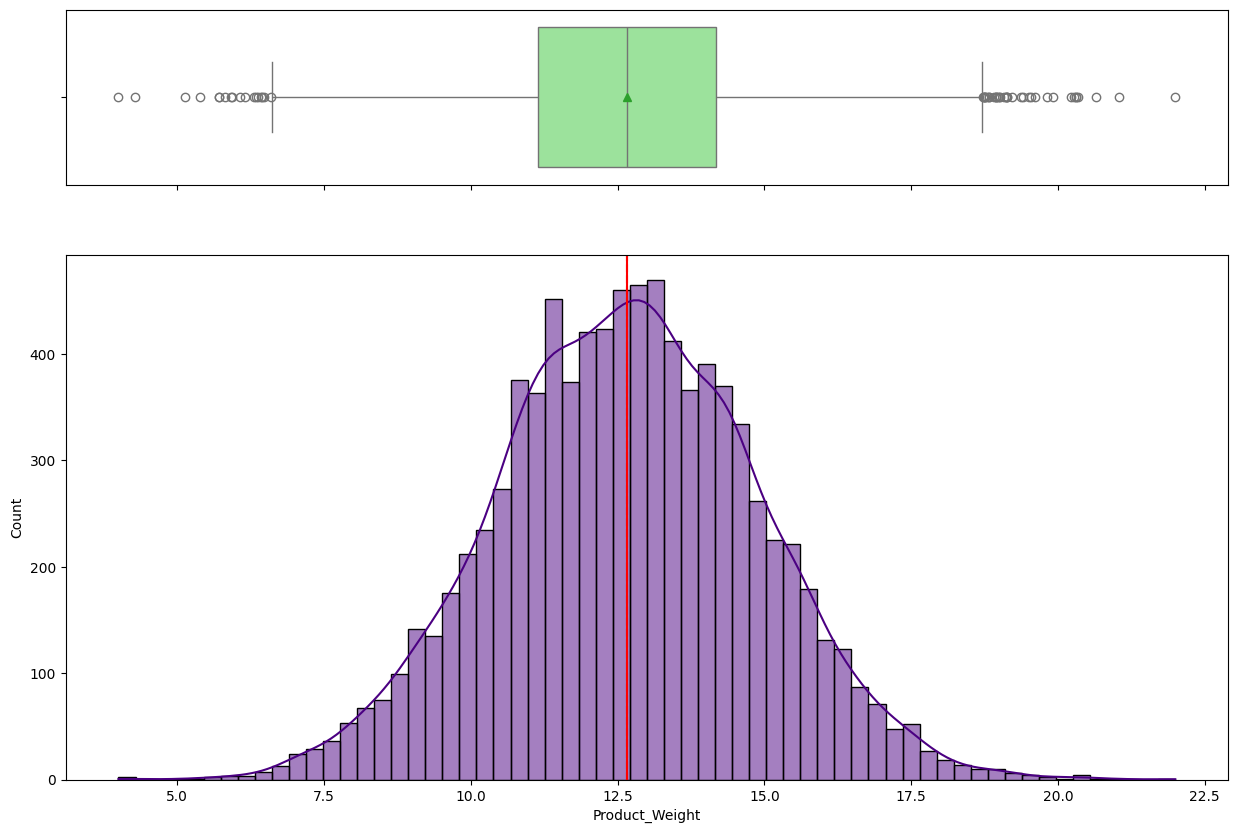

In [18]:
# Plotting histogram and boxplot for Product_Weight
histogram_boxplot(dataset, 'Product_Weight')

The distribution of Product_Weight appear relatively uniform, indicating a balanced spread of values across its range.

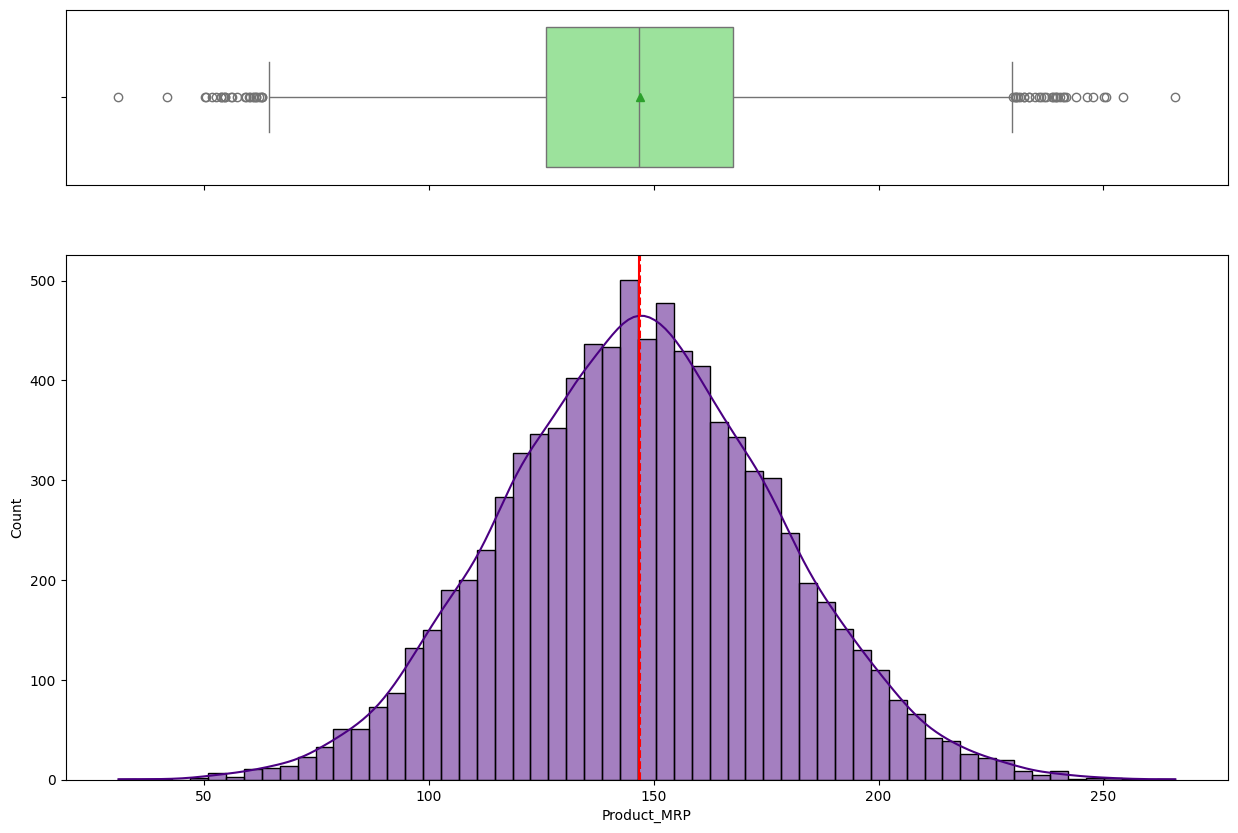

In [19]:
# Plotting histogram and boxplot for Product_MRP
histogram_boxplot(dataset, 'Product_MRP')

The distribution of Product_MRP appear relatively uniform, indicating a balanced spread of values across its range.

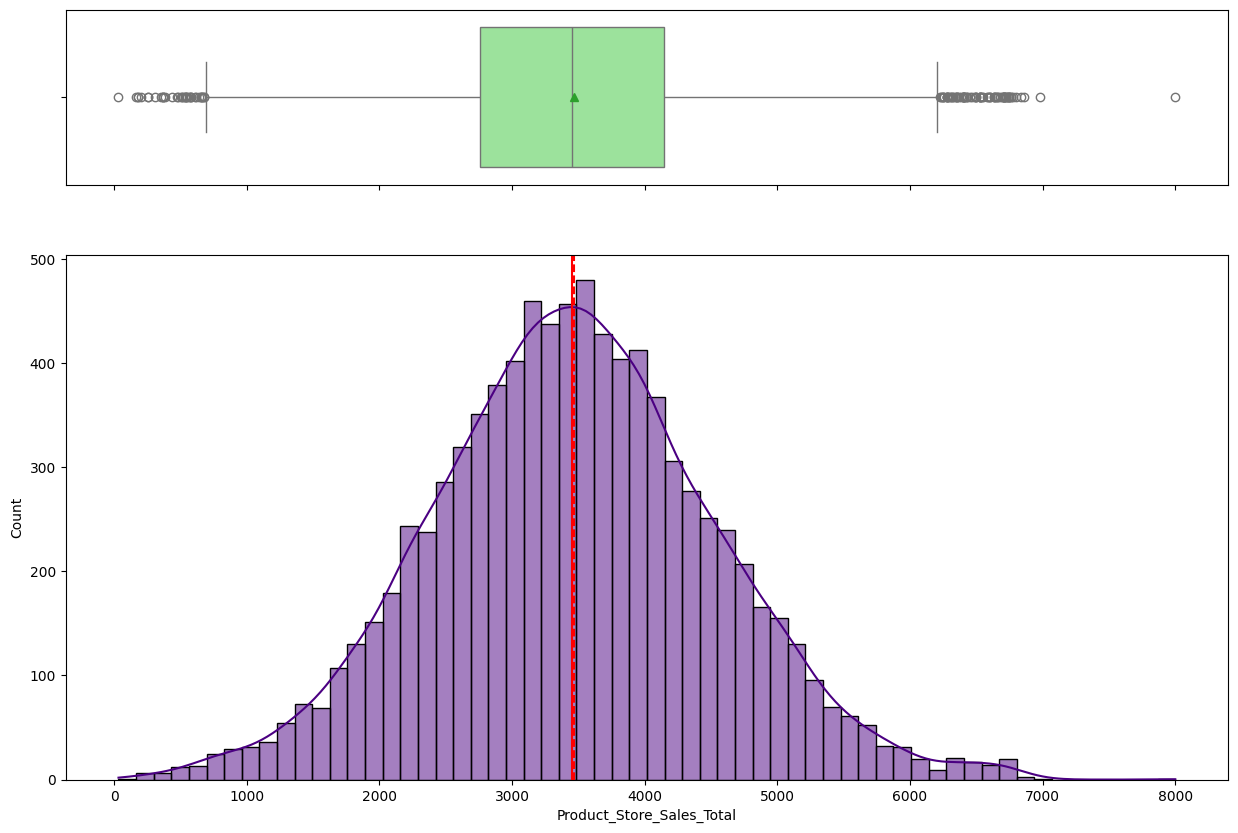

In [20]:
# Plotting histogram and boxplot for Product_Store_Sales_Total
histogram_boxplot(dataset, 'Product_Store_Sales_Total')

The distribution of Product_Store_Sales_Total appear relatively uniform, indicating a balanced spread of values across its range.

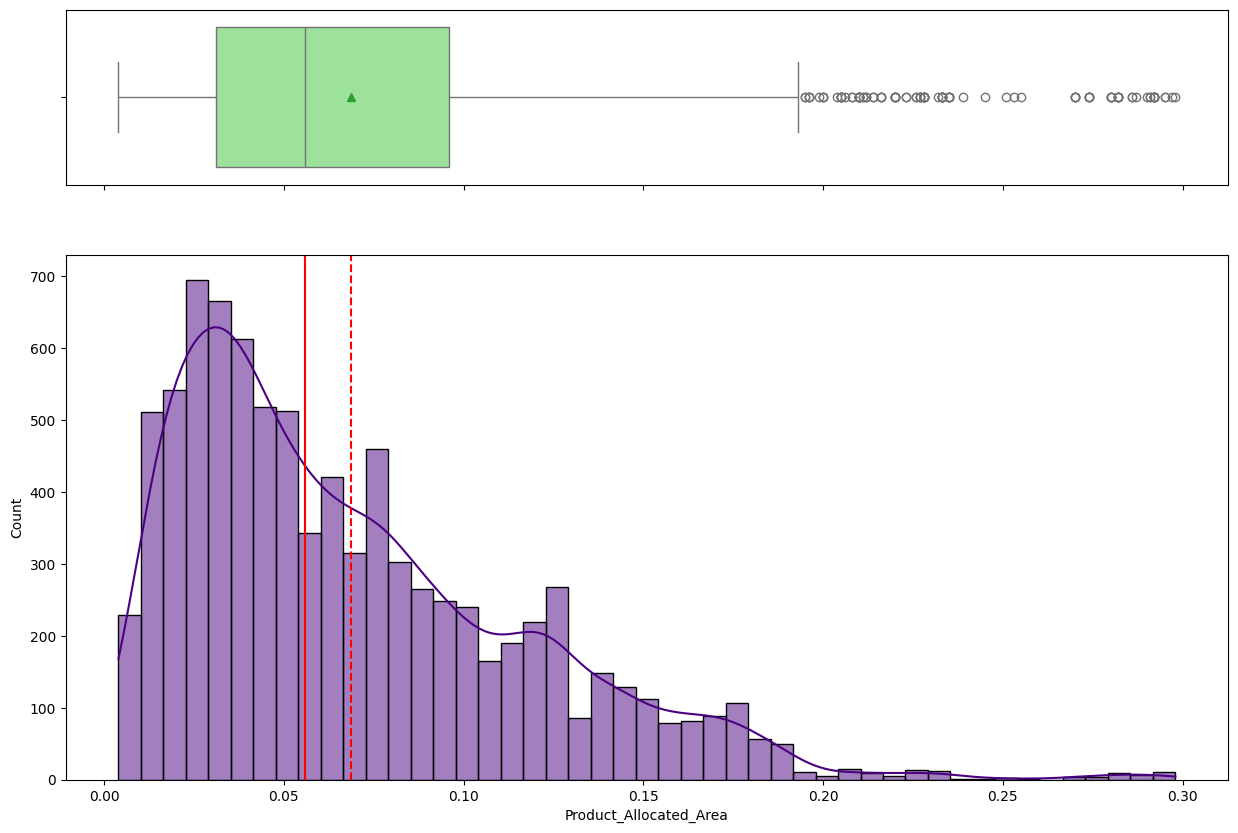

In [21]:
# Plotting histogram and boxplot for Product_Allocated_Area
histogram_boxplot(dataset, 'Product_Allocated_Area')

Product_Allocated_Area exhibits a right-skewed distribution, suggesting that most products occupy smaller areas, with a few products allocated significantly larger space.


### Labeled Bar Plots

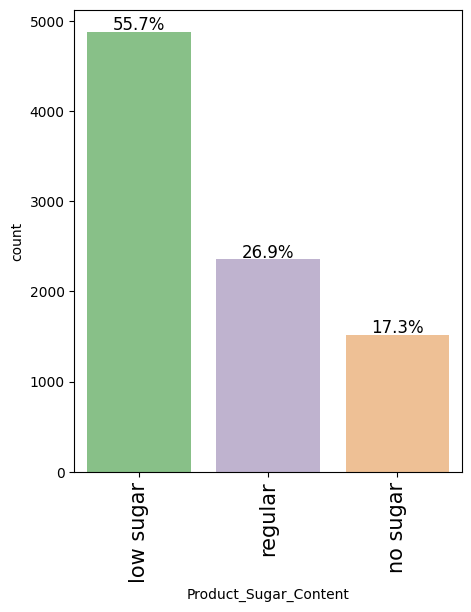

In [22]:
# Plotting a labeled bar chart showing Product_Sugar_Content distribution
labeled_barplot(dataset, 'Product_Sugar_Content', perc=True)

A majority of products in the dataset are categorized as low-sugar, indicating a strong representation of healthier food options.

<Figure size 1000x1200 with 0 Axes>

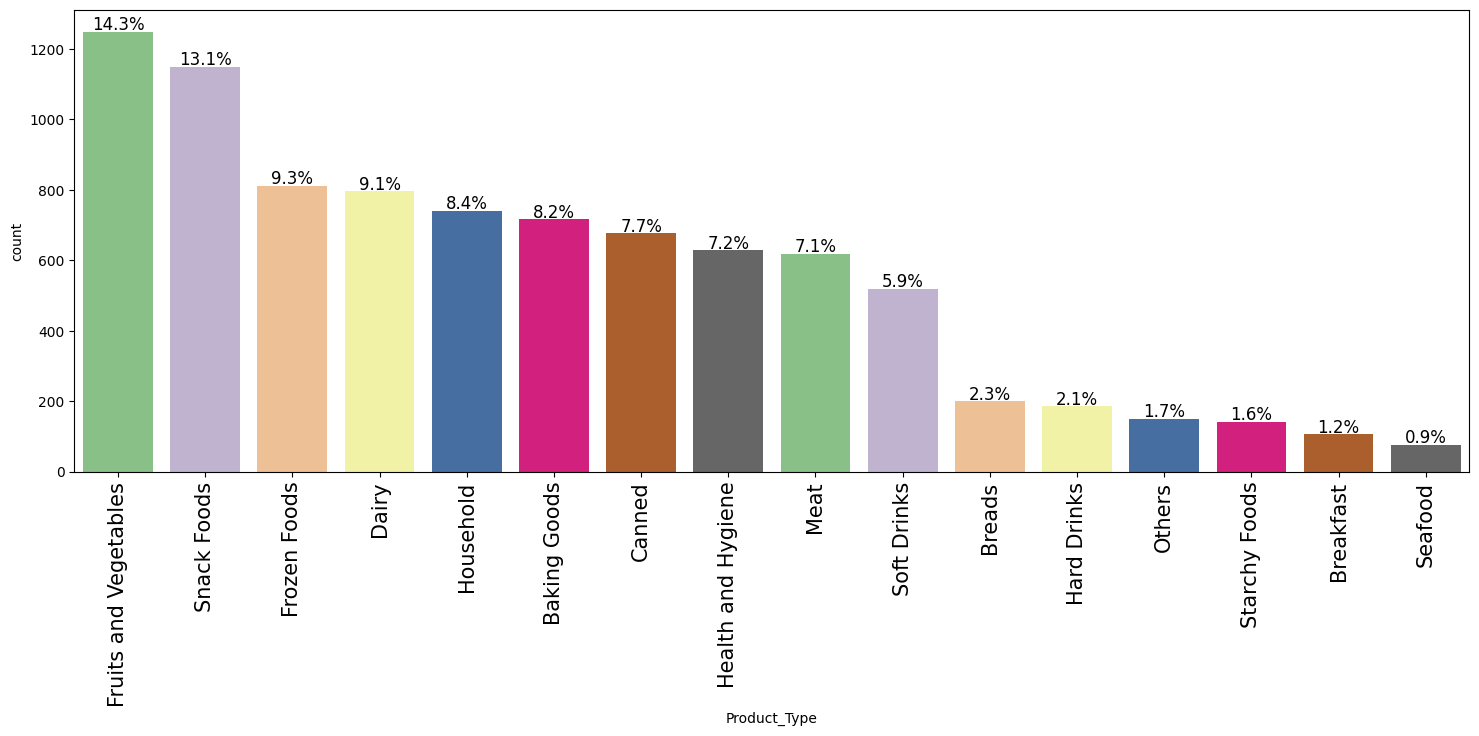

In [23]:
# Plotting a labeled bar chart showing Product_Type distribution
plt.figure(figsize=(10,12))
labeled_barplot(dataset, 'Product_Type', perc=True)

Among all product categories, fruits and vegetables constitute the largest share, highlighting their dominance in the overall product mix.

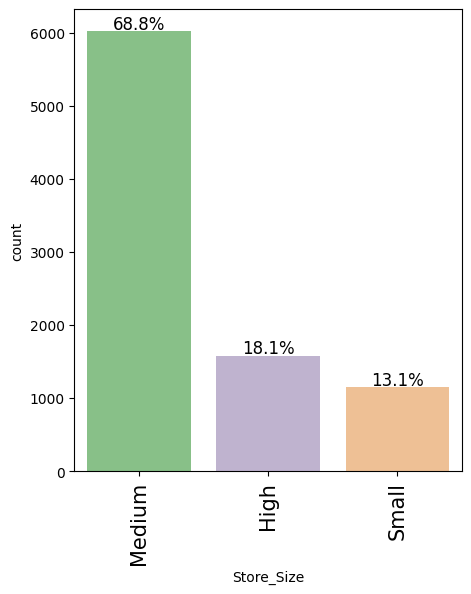

In [24]:
# Plotting a labeled bar chart showing Store_Size distribution
labeled_barplot(dataset, 'Store_Size', perc=True)

Most retail outlets fall under the medium store size category, suggesting a standardized store format across locations.

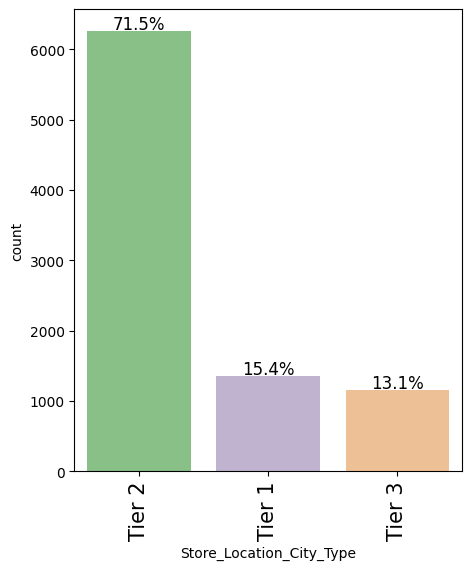

In [25]:
# Plotting a labeled bar chart showing Store_Location_City_Type distribution
labeled_barplot(dataset, 'Store_Location_City_Type', perc=True)

 A significant proportion of stores are situated in Tier-2 cities, pointing toward a strong retail presence beyond metropolitan areas.

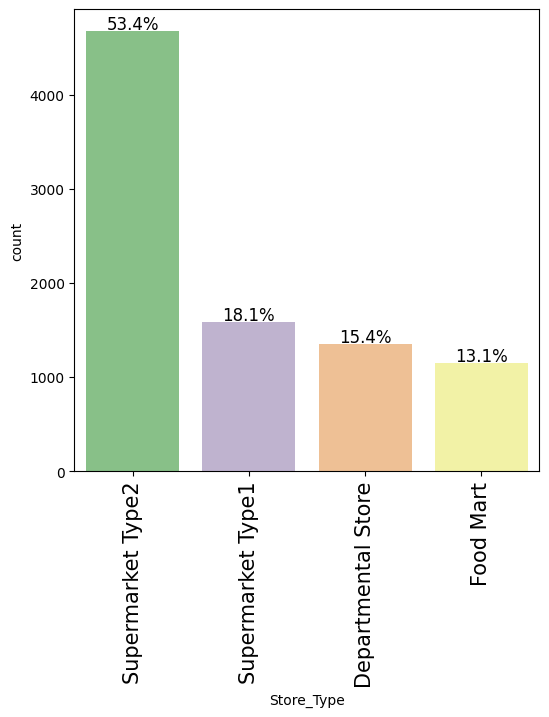

In [26]:
# Plotting a labeled bar chart showing Store_Type distribution
labeled_barplot(dataset, 'Store_Type', perc=True)

Supermarket Type-2 emerges as the most prevalent store format, outperforming other store types in representation.

## Bivariate Analysis

### Heatmap

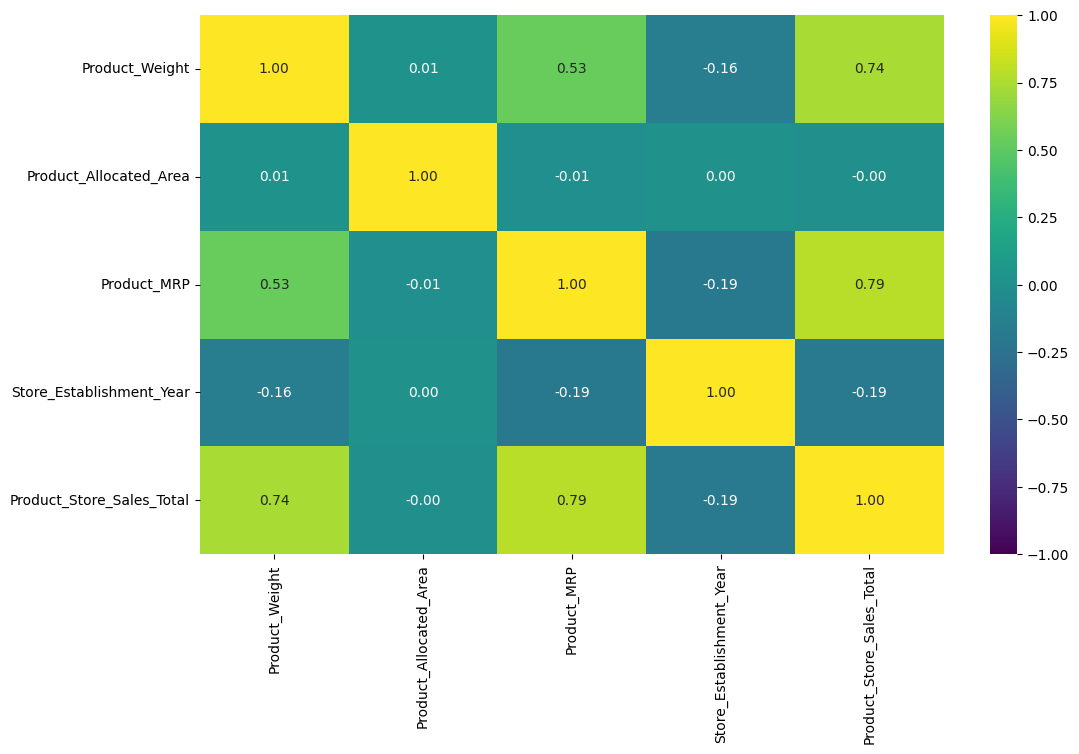

In [27]:
# Including only numerical columns
num_cols = ['Product_Weight', 'Product_Allocated_Area', 'Product_MRP', 'Store_Establishment_Year', 'Product_Store_Sales_Total']
cols_list = [col for col in dataset.columns if col in num_cols]

# plotting the heatmap

plt.figure(figsize=(12, 7))
sns.heatmap(
    dataset[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="viridis"
)
plt.show()

- Product_MRP exhibits the strongest positive correlation with Product_Store_Sales_Total, indicating that higher-priced products tend to generate greater sales revenue.

- Product_Weight also shows a notable positive correlation with total sales, suggesting that heavier products may contribute to higher revenue per transaction.

- A negative correlation is observed between Store_Establishment_Year and Product_Store_Sales_Total, implying that older stores generally achieve higher sales compared to newer ones.

- Additionally, Product_MRP and Product_Weight are positively correlated, hinting that larger or heavier products are often priced higher.

In [28]:
# Function to plot stacked bar plot
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

### Stacked Bar Plots

Product_Type           Baking Goods  Breads  Breakfast  Canned  Dairy  \
Product_Sugar_Content                                                   
All                             716     200        106     677    796   
low sugar                       462     148         65     402    590   
regular                         254      52         41     275    206   
no sugar                          0       0          0       0      0   

Product_Type           Frozen Foods  Fruits and Vegetables  Hard Drinks  \
Product_Sugar_Content                                                     
All                             811                   1249          186   
low sugar                       531                    864          128   
regular                         280                    385           58   
no sugar                          0                      0            0   

Product_Type           Health and Hygiene  Household  Meat  Others  Seafood  \
Product_Sugar_Content          

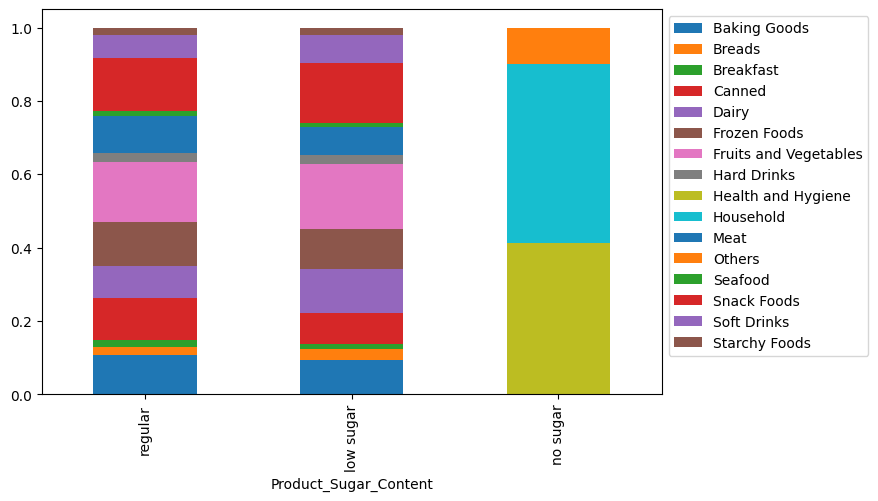

In [29]:
# Plotting Stacked Bar Plot(Product_Sugar_Content vs Product_Type)
stacked_barplot(dataset, "Product_Sugar_Content", "Product_Type")

- Low-sugar products dominate the dataset, contributing the highest counts across most food categories such as Fruits & Vegetables, Snack Foods, Frozen Foods, and Dairy.

- Regular sugar products form the second-largest share, particularly visible in Snack Foods, Frozen Foods, and Canned items.

- No-sugar products are highly category-specific—they appear exclusively in Health & Hygiene, Household, and Others, indicating these are largely non-edible or non-sweet consumables.

Store_Type  Departmental Store  Food Mart  Supermarket Type1  \
Store_Size                                                     
All                       1349       1152               1586   
Small                        0       1152                  0   
Medium                    1349          0                  0   
High                         0          0               1586   

Store_Type  Supermarket Type2   All  
Store_Size                           
All                      4676  8763  
Small                       0  1152  
Medium                   4676  6025  
High                        0  1586  
------------------------------------------------------------------------------------------------------------------------


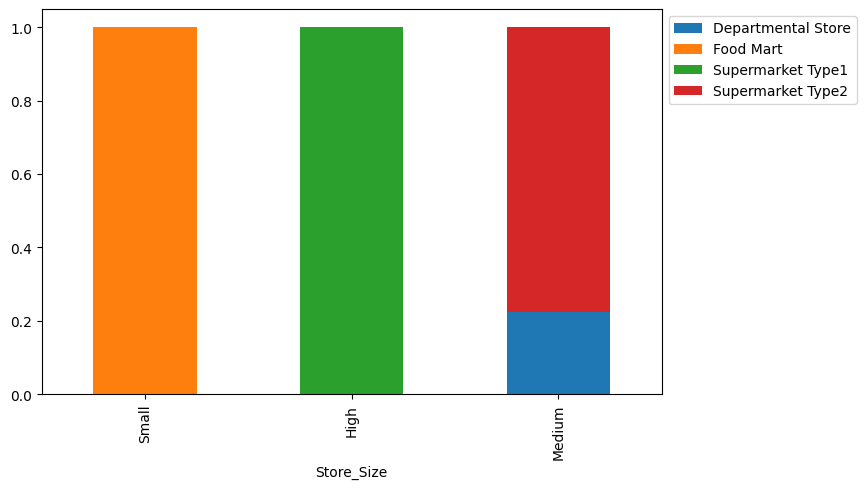

In [30]:
# Plotting Stacked Bar Plot(Store_Size vs Store_Type)
stacked_barplot(dataset, "Store_Size", "Store_Type")

- It is observed that small-sized stores are predominantly food marts, whereas large-sized stores are mainly Supermarket Type 1.

- Medium-sized stores are largely Supermarket Type 2, with a smaller proportion operating as departmental stores.

Store_Type                Departmental Store  Food Mart  Supermarket Type1  \
Store_Location_City_Type                                                     
All                                     1349       1152               1586   
Tier 3                                     0       1152                  0   
Tier 2                                     0          0               1586   
Tier 1                                  1349          0                  0   

Store_Type                Supermarket Type2   All  
Store_Location_City_Type                           
All                                    4676  8763  
Tier 3                                    0  1152  
Tier 2                                 4676  6262  
Tier 1                                    0  1349  
------------------------------------------------------------------------------------------------------------------------


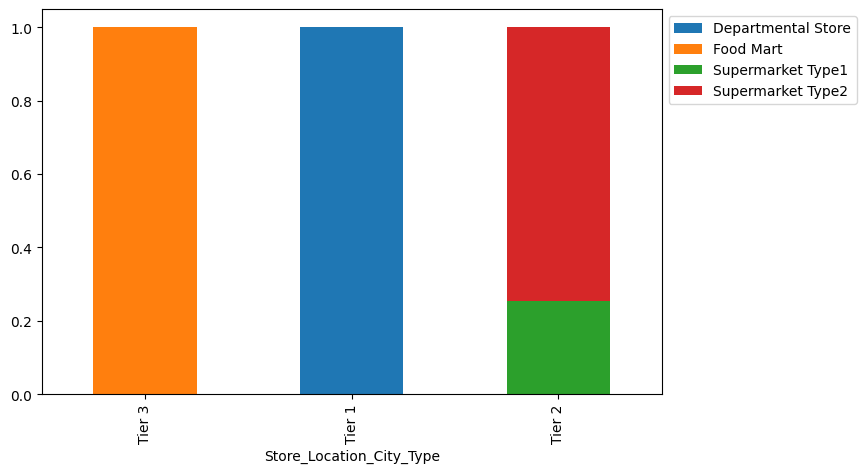

In [31]:
# Plotting Stacked Bar Plot(Store_Location_City_Type vs Store_Type)
stacked_barplot(dataset, "Store_Location_City_Type", "Store_Type")

- Tier 1 cities host only Departmental Stores, indicating a preference for larger, full-format retail outlets in metro areas.

- Tier 3 cities consist exclusively of Food Marts, reflecting demand for smaller, convenience-focused stores in less urbanized locations.

- Tier 2 cities are dominated by Supermarkets, with Supermarket Type 2 being the most prevalent, followed by Supermarket Type 1.

Product_Type        Baking Goods  Breads  Breakfast  Canned  Dairy  \
Store_Type                                                           
All                          716     200        106     677    796   
Supermarket Type2            385     113         62     380    397   
Departmental Store            99      34         19      90    145   
Supermarket Type1            136      30         10     119    150   
Food Mart                     96      23         15      88    104   

Product_Type        Frozen Foods  Fruits and Vegetables  Hard Drinks  \
Store_Type                                                             
All                          811                   1249          186   
Supermarket Type2            446                    700           95   
Departmental Store           122                    182           23   
Supermarket Type1            142                    199           38   
Food Mart                    101                    168           30   

Prod

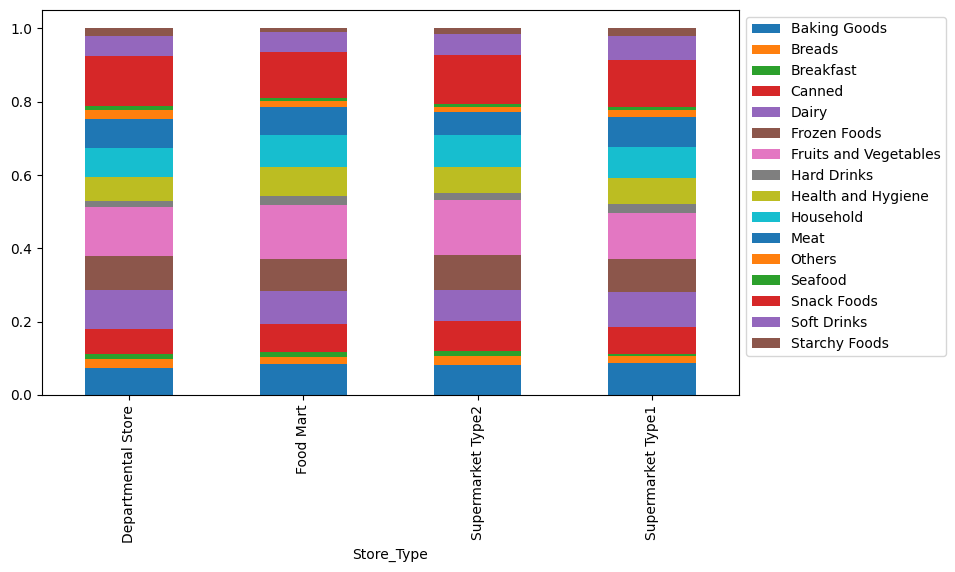

In [32]:
# Plotting Stacked Bar Plot(Store_Type vs Product_Type)
stacked_barplot(dataset, "Store_Type","Product_Type")

- Supermarket Type 2 dominates across all product categories, contributing the highest number of items in every major segment such as Snack Foods, Fruits & Vegetables, Dairy, and Frozen Foods. This aligns with its highest overall store count.

- Food Marts stock fewer items overall and carry relatively lower counts across categories, consistent with their smaller store size and convenience-oriented model.

- Departmental Stores maintain a balanced product mix, with moderate representation across food and non-food categories such as Health & Hygiene and Household, reflecting a wide-assortment strategy.

- Supermarket Type 1 shows stronger presence in fresh and staple categories like Fruits & Vegetables, Meat, and Dairy compared to Food Marts, suggesting a focus on core grocery items.

## Multivariate Analysis

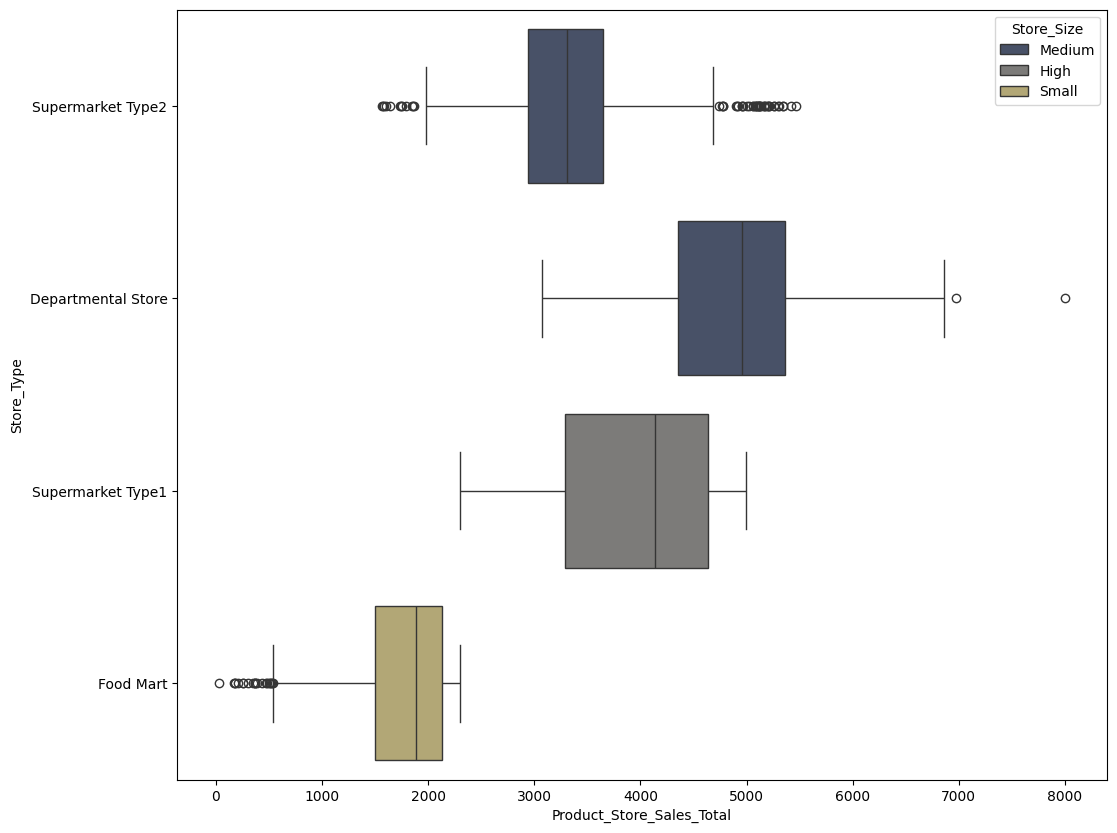

In [33]:
# Plotting boxplot to analyze the distribution of total product sales
fig = plt.figure(figsize=(12,10))
sns.boxplot(data=dataset,y= "Store_Type",x= "Product_Store_Sales_Total",hue="Store_Size",palette='cividis')
plt.show()

- Departmental Stores record the highest median sales, indicating stronger overall sales performance compared to other store types. They also show a wide spread, suggesting high variability in sales across locations.

- Supermarket Type 1 and Supermarket Type 2 exhibit similar sales ranges, but Supermarket Type 1 has a slightly higher median, implying marginally better sales consistency.

- Supermarket Type 2 shows more lower-end outliers, indicating that some stores underperform despite the overall moderate-to-high sales range.

- Food Marts have the lowest median sales and the narrowest interquartile range, reflecting limited sales capacity and more consistent but lower sales volumes—typical of small-sized stores.

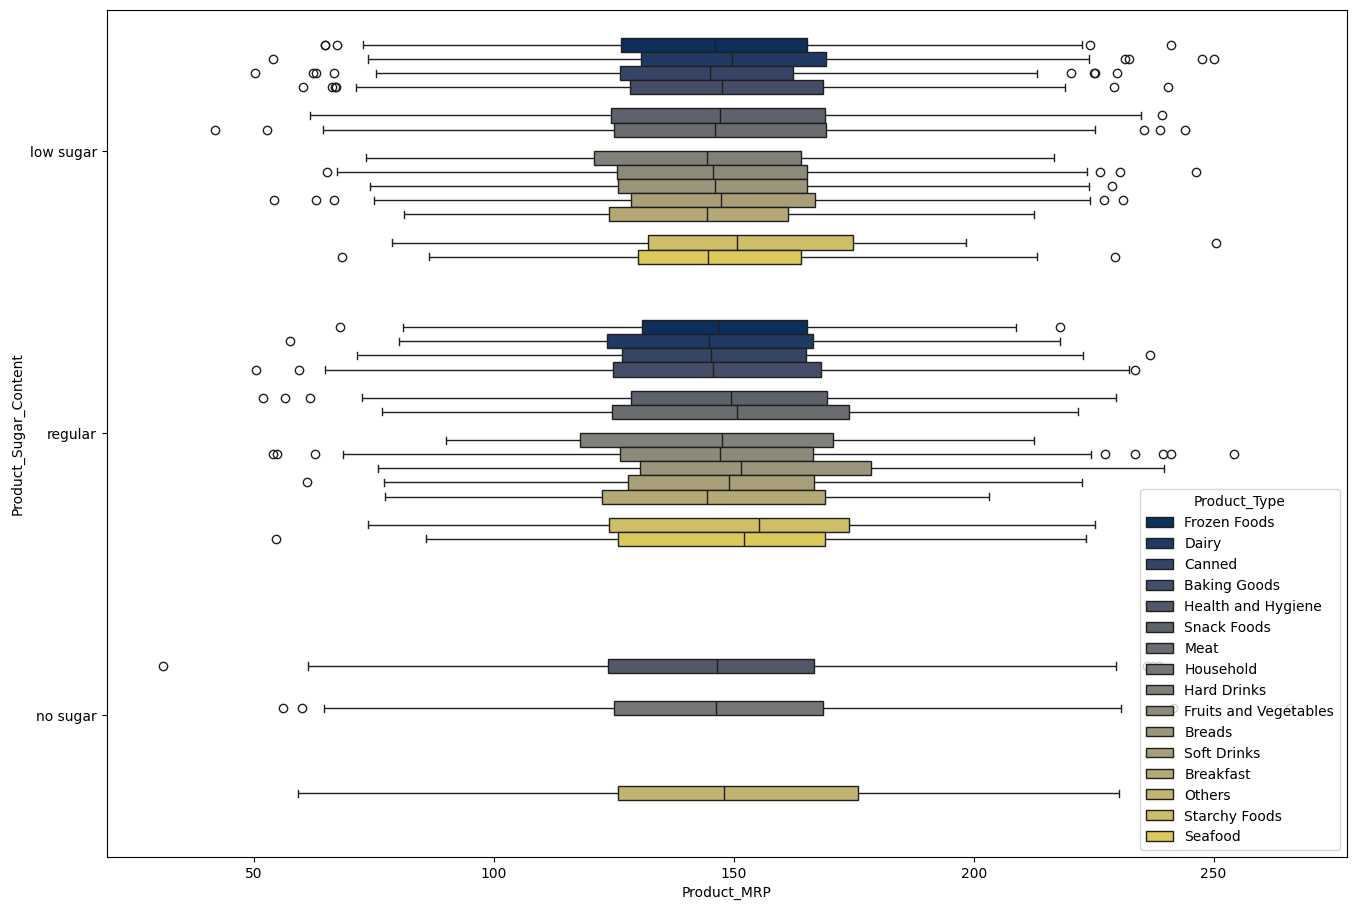

In [34]:
# Plotting boxplot to analyze the distribution of Product_MRP and Product_Sugar_Content with respect to Product_Type
fig = plt.figure(figsize=(16,11))
sns.boxplot(data=dataset,y= "Product_Sugar_Content",x= "Product_MRP",hue="Product_Type",palette='cividis')
plt.show()

- Low-sugar and regular-sugar products show very similar MRP distributions across most product categories, indicating that sugar content alone does not significantly drive pricing.

- Regular-sugar products exhibit slightly higher upper-range MRPs and more high-price outliers in categories like Snack Foods, Soft Drinks, and Frozen Foods, suggesting premium variants within regular products.

- No-sugar products are limited to fewer categories and show a wider spread in MRP, particularly in Health & Hygiene, Household, and Others, reflecting pricing differences driven more by product function than ingredients.


# **Data Preprocessing**

### Outlier Detection

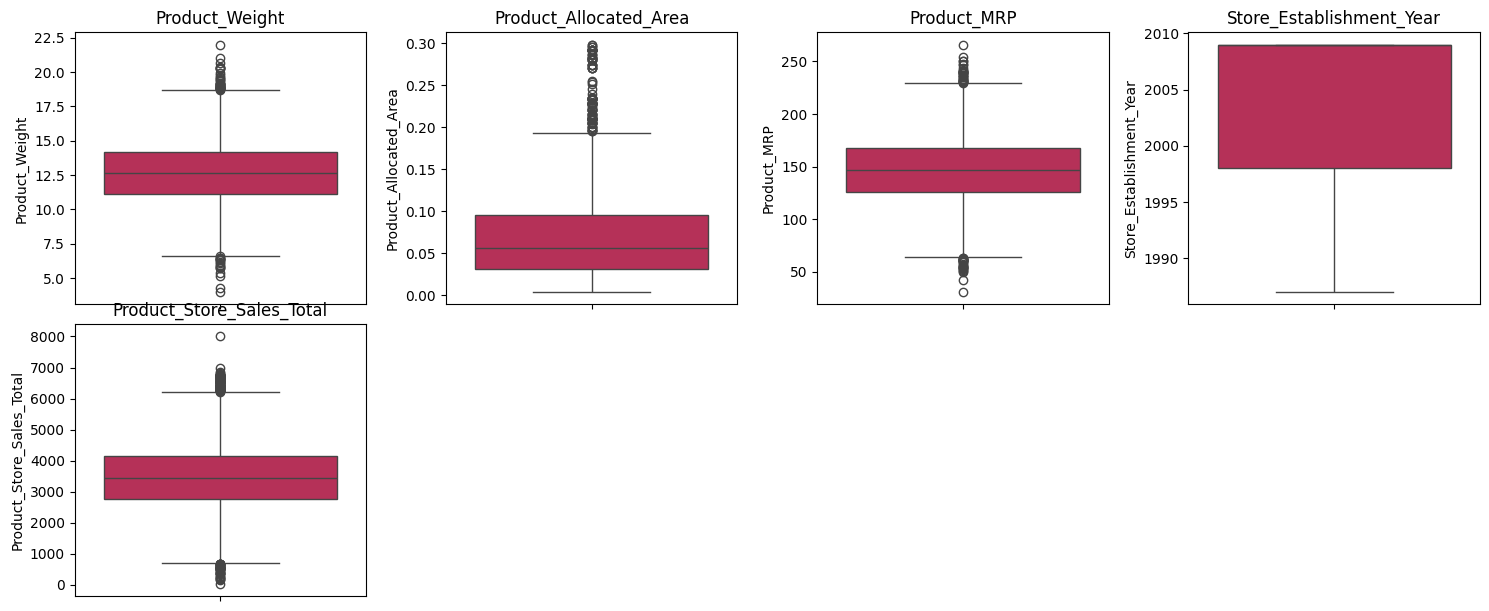

In [35]:
# Outlier detection using boxplots

# Selecting only numeric columns from the dataset
numeric_columns = dataset.select_dtypes(include=np.number).columns.tolist()

# Creating a large figure to fit multiple subplots
plt.figure(figsize=(15, 12))

# Looping through each numeric column
for i, variable in enumerate(numeric_columns):

    # Creating a subplot grid (4 rows x 4 columns)
    plt.subplot(4, 4, i + 1)

    # Plotting boxplot for the current variable
    sns.boxplot(dataset[variable], whis=1.5, palette="rocket")

    # Adjusting spacing between subplots to avoid overlap
    plt.tight_layout()

    # Setting title as the column name
    plt.title(variable)

# Displaying all boxplots
plt.show()


Most outliers appear business-driven and valid; however, one clear data error is identified where total sales are less than MRP and should be treated as an invalid outlier.

### Outlier Treatment

In [36]:
# Identifying records where total sales are less than MRP (business-rule outlier)
mask = dataset['Product_Store_Sales_Total'] < dataset['Product_MRP']
mask.sum(), len(dataset)

(np.int64(1), 8763)

In [37]:
# Keeping only records where total sales are at least the product MRP
dataset = dataset[
    dataset['Product_Store_Sales_Total'] >= dataset['Product_MRP']
]

In [38]:
mask = dataset['Product_Store_Sales_Total'] < dataset['Product_MRP']  # identifying records where total sales are less than the product MRP
mask.sum(), len(dataset)  # counting such records and show total number of rows in the dataset


(np.int64(0), 8762)

In [39]:
 # Creating pipeline to preprocess numerical features by scaling them
numeric_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())  # standardizing numerical features to zero mean and unit variance
])

# Creating pipeline to preprocess categorical features using one-hot encoding
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # one-hot encoding categorical features and safely handle unseen categories
])



In [93]:
# Defining the target variable to be predicted (total product sales)
target = 'Product_Store_Sales_Total'

# List of numerical features used for model training
numeric_features = [
    'Product_Weight',
    'Product_Allocated_Area',
    'Product_MRP',
    'Store_Establishment_Year'
]


# List of categorical features used for model training
categorical_features = [
    'Product_Sugar_Content',
    'Product_Type',
    'Store_Size',
    'Store_Location_City_Type',
    'Store_Type'
]


# Combining numerical and categorical preprocessing into a single transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        # applying numeric preprocessing pipeline to numerical columns

        ('cat', categorical_pipeline, categorical_features)
        # applying categorical preprocessing pipeline to categorical columns
    ]
)



In [94]:
# Selecting input features (both numerical and categorical columns)
X = dataset[numeric_features + categorical_features]

# Selecting target variable to be predicted
y = dataset[target]

In [96]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# **Model Building**

## Define functions for Model Evaluation

In [97]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mean_absolute_percentage_error(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

### Metrics of Choice

MAPE is preferred as the metric of choice over RMSE and MAE as it provides an intuitive, normalized measure of prediction accuracy and better supports model comparison and business decision-making.

## Model Building

## Random Forest Regressor

In [98]:
# Initializing Random Forest regression model with fixed random state
rf_model = RandomForestRegressor(random_state=42)

# Creating a pipeline that first preprocesses data, then trains the model
rf_pipeline = make_pipeline(preprocessor, rf_model)

# Training the pipeline using training features and target values
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Product_Weight',
                                                   'Product_Allocated_Area',
                                                   'Product_MRP',
                                                   'Store_Establishment_Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Product_Sugar_Content',
                                                   'Product_Type', 'Store_Size',
                                                   'Store_Location_City_Type',
                                                   'Store_Type'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [99]:
# Evaluating model performance on training data
train_perf = model_performance_regression(rf_pipeline, X_train, y_train)
train_perf  # Displaying training performance metrics


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,106.467232,40.31979,0.989993,0.98998,0.014195


In [100]:
# Evaluating model performance on test data
test_perf = model_performance_regression(rf_pipeline,X_test,y_test)
test_perf  # Displaying test performance metrics

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,291.204547,110.061847,0.925512,0.925128,0.040685


- The model performs exceptionally well on training data (very low RMSE/MAE, R² ≈ 0.99, and MAPE ≈ 1.4%), indicating an excellent fit.

- On test data, performance drops (higher RMSE/MAE, R² ≈ 0.93, MAPE ≈ 4.1%), which suggests some level of overfitting, though the model still generalizes reasonably well.

### Let’s apply hyperparameter tuning to reduce overfitting and improve test performance.

## Random Forest Regressor - Hyperparameter Tuning

In [101]:
# Initializing a new Random Forest regressor for hyperparameter tuning
rf_tuned = RandomForestRegressor(random_state=42)

# Creating a pipeline combining preprocessing and the Random Forest model
rf_pipeline = make_pipeline(preprocessor, rf_tuned)

# Defining the hyperparameter grid for tuning
parameters = {
    'randomforestregressor__max_depth': [3, 4, 5, 6],  # depth of each tree
    'randomforestregressor__max_features': ['sqrt', 'log2', None],  # number of features considered at each split
    'randomforestregressor__n_estimators': [50, 75, 100, 125, 150]  # number of trees in the forest
}

# Defining the scoring metric as R-squared
scorer = metrics.make_scorer(metrics.r2_score)

# Performing grid search with 5-fold cross-validation
grid_obj = GridSearchCV(rf_pipeline, param_grid=parameters, scoring=scorer, cv=5)

# Fitting grid search to training data to find the best hyperparameters
grid_obj = grid_obj.fit(X_train, y_train)

# Retrieving the best model from grid search
rf_tuned = grid_obj.best_estimator_

# Training the tuned Random Forest pipeline on the full training set
rf_tuned.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Product_Weight',
                                                   'Product_Allocated_Area',
                                                   'Product_MRP',
                                                   'Store_Establishment_Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Product_Sugar_Content',
                                                   'Product_Type', 'Store_Size',
                                                   'Store_Location_City_Type',
                                                   'Store_Type'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=6, max_features=None,
                                       n_estimators=150, random_state=42))])

In [102]:
# Evaluating model performance on training data
train_perf_rfhp = model_performance_regression(rf_tuned,X_train,y_train)
train_perf_rfhp # Displaying training performance metrics

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,291.12665,155.847223,0.925174,0.925077,0.054238


In [103]:
# Evaluating model performance on test data
test_perf_rfhp = model_performance_regression(rf_tuned,X_test,y_test)
test_perf_rfhp # Displaying test performance metrics

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,321.417897,169.573094,0.909254,0.908785,0.06106


- The model shows similar performance on training and test data, with only a small increase in RMSE, MAE, and MAPE on the test set.

- The close R² values (Train ≈ 0.93, Test ≈ 0.91) indicate reduced overfitting and better generalization compared to earlier results.

- Although overall accuracy is slightly lower, the model is more stable and reliable on unseen data after tuning.

## XGBoost Regressor

In [104]:
# Initializing XGBoost regressor with a fixed random state
xgbmodel = XGBRegressor(random_state=42)

# Creating a pipeline combining preprocessing and the XGBoost model
xgb_pipeline = make_pipeline(preprocessor, xgbmodel)

# Training the XGBoost pipeline on the training data
xgb_pipeline.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Product_Weight',
                                                   'Product_Allocated_Area',
                                                   'Product_MRP',
                                                   'Store_Establishment_Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Product_Sugar_Content',
                                                   'Product_Type', 'Store_...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [105]:
# Evaluating model performance on training data
xgb_train_perf = model_performance_regression(xgb_pipeline, X_train, y_train)
xgb_train_perf # Displaying training performance metrics

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,128.981785,61.985318,0.985312,0.985294,0.020834


In [106]:
# Evaluating model performance on test data
xgb_test_perf = model_performance_regression(xgb_pipeline, X_test, y_test)
xgb_test_perf # Displaying test performance metrics

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,308.602806,132.936858,0.916346,0.915914,0.049539


- The model demonstrates very strong training performance (R² ≈ 0.99, low RMSE/MAE, and MAPE ≈ 2.1%), indicating an excellent fit on the training data.

- However, test performance drops notably (higher RMSE/MAE, R² ≈ 0.92, MAPE ≈ 5.0%), suggesting the model is still overfitting.


### Let’s apply hyperparameter tuning to reduce overfitting and improve test performance.

## XGBoost Regressor- Hyperparameter Tuning

In [107]:
# Initializing XGBoost regressor with a fixed random state
xgbmodel = XGBRegressor(random_state=42)

# Creating a pipeline combining preprocessing and the XGBoost model
xgbpipelineht = make_pipeline(preprocessor, xgbmodel)

# Defining hyperparameter grid for tuning XGBoost
param_grid = {
    'xgbregressor__n_estimators': [50, 100, 150, 200],       # number of boosting rounds
    'xgbregressor__max_depth': [2, 3, 4],                     # maximum tree depth
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1],         # step size shrinkage
    'xgbregressor__colsample_bytree': [0.4, 0.5, 0.6],        # subsample ratio of columns per tree
    'xgbregressor__colsample_bylevel': [0.4, 0.5, 0.6],       # subsample ratio per tree level
    'xgbregressor__reg_lambda': [0.4, 0.5, 0.6]              # L2 regularization term
}

# Defining scoring metric as R-squared
scorer = metrics.make_scorer(metrics.r2_score)

# Setting up grid search with 5-fold cross-validation
grid_obj = GridSearchCV(
    xgbpipelineht,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=1
)

# Fitting grid search to training data to find the best hyperparameters
grid_obj.fit(X_train, y_train)

# Retrieving the best pipeline from grid search
xgb_tuned = grid_obj.best_estimator_

# Training the tuned XGBoost pipeline on the full training set
xgb_tuned.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Product_Weight',
                                                   'Product_Allocated_Area',
                                                   'Product_MRP',
                                                   'Store_Establishment_Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Product_Sugar_Content',
                                                   'Product_Type', 'Store_...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [108]:
# Evaluating model performance on training data
xgbtuned_train_performance = model_performance_regression(xgb_tuned, X_train, y_train)
xgbtuned_train_performance # Displaying training performance metrics

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,255.545389,107.945243,0.942346,0.942272,0.039149


In [109]:
# Evaluating model performance on test data
xgbtuned_test_performance = model_performance_regression(xgb_tuned, X_test, y_test)
xgbtuned_test_performance # Displaying test performance metrics

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,307.823732,129.620738,0.916767,0.916338,0.048684


- The tuned model shows slightly reduced training performance compared to the untuned version, with lower R² and marginally higher RMSE/MAE, indicating that the model complexity has been effectively controlled.
- On the test data, performance improves and becomes more consistent with the training results (R² ≈ 0.92, lower error gap, and MAPE ≈ 5%), demonstrating better generalization.

# **Model Performance Comparison, Final Model Selection, and Serialization**

In [110]:
# Combining training performance metrics of all models into a single DataFrame for comparison
models_train_comp_df = pd.concat(
    {
        'Random Forest Estimator': train_perf,
        'Random Forest Estimator-Tuned': train_perf_rfhp,
        'XGBoost Estimator': xgb_train_perf,
        'XGBoost Estimator-Tuned': xgbtuned_train_performance,
    },
    axis=1
)

# Transposing the DataFrame to have models as rows and metrics as columns for easier readability
models_train_comp_df.T


0
Random Forest Estimator       RMSE            106.467232
                              MAE              40.319790
                              R-squared         0.989993
                              Adj. R-squared    0.989980
                              MAPE              0.014195
Random Forest Estimator-Tuned RMSE            291.126650
                              MAE             155.847223
                              R-squared         0.925174
                              Adj. R-squared    0.925077
                              MAPE              0.054238
XGBoost Estimator             RMSE            128.981785
                              MAE              61.985318
                              R-squared         0.985312
                              Adj. R-squared    0.985294
                              MAPE              0.020834
XGBoost Estimator-Tuned       RMSE            255.545389
                              MAE             107.945243
                              R-squared         0.942346
                              Adj. R-squared    0.942272
                              MAPE              0.039149

In [111]:
# Combining test performance metrics of all models into a single DataFrame for comparison
models_test_comp_df = pd.concat(
    {
        'Random Forest Estimator': test_perf,
        'Random Forest Estimator-Tuned': test_perf_rfhp,
        'XGBoost Estimator': xgb_test_perf,
        'XGBoost Estimator-Tuned': xgbtuned_test_performance,
    },
    axis=1
)
# Transposing the DataFrame to have models as rows and metrics as columns for easier readability
models_test_comp_df.T

0
Random Forest Estimator       RMSE            291.204547
                              MAE             110.061847
                              R-squared         0.925512
                              Adj. R-squared    0.925128
                              MAPE              0.040685
Random Forest Estimator-Tuned RMSE            321.417897
                              MAE             169.573094
                              R-squared         0.909254
                              Adj. R-squared    0.908785
                              MAPE              0.061060
XGBoost Estimator             RMSE            308.602806
                              MAE             132.936858
                              R-squared         0.916346
                              Adj. R-squared    0.915914
                              MAPE              0.049539
XGBoost Estimator-Tuned       RMSE            307.823732
                              MAE             129.620738
                              R-squared         0.916767
                              Adj. R-squared    0.916338
                              MAPE              0.048684

In [112]:
# Calculating the difference in performance metrics between training and test sets
diff = (models_train_comp_df - models_test_comp_df)

# Transposing the difference DataFrame to have models as rows for easier comparison
diff.T


0
Random Forest Estimator       RMSE           -184.737315
                              MAE             -69.742057
                              R-squared         0.064480
                              Adj. R-squared    0.064852
                              MAPE             -0.026491
Random Forest Estimator-Tuned RMSE            -30.291246
                              MAE             -13.725871
                              R-squared         0.015920
                              Adj. R-squared    0.016292
                              MAPE             -0.006821
XGBoost Estimator             RMSE           -179.621021
                              MAE             -70.951540
                              R-squared         0.068967
                              Adj. R-squared    0.069380
                              MAPE             -0.028704
XGBoost Estimator-Tuned       RMSE            -52.278343
                              MAE             -21.675495
                              R-squared         0.025579
                              Adj. R-squared    0.025934
                              MAPE             -0.009535

The tuned Random Forest regressor is selected as the final model as it delivers the lowest prediction error across RMSE, MAE, and MAPE, making it the most reliable and business-ready model despite a marginally lower R² compared to untuned XGBoost.”

## Model Serialization

In [113]:
# File path where the trained sales prediction model is saved
saved_model_path = '/content/drive/MyDrive/backend_files/product_total_sales_prediction_model_v1_1.joblib'

In [114]:
# Serializing and saving the model to disk for future inference
joblib.dump(xgb_tuned,saved_model_path)

['/content/drive/MyDrive/backend_files/product_total_sales_prediction_model_v1_1.joblib']

In [115]:
# Loading the trained sales prediction model from disk for inference
saved_model = joblib.load(saved_model_path)
saved_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Product_Weight',
                                                   'Product_Allocated_Area',
                                                   'Product_MRP',
                                                   'Store_Establishment_Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Product_Sugar_Content',
                                                   'Product_Type', 'Store_...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [116]:
# Generating predictions on the test dataset using the loaded trained model
saved_model.predict(X_test)

array([3410.943 , 3669.65  , 2502.736 , ..., 3552.747 , 2801.0105,
       4465.592 ], dtype=float32)

# **Deployment - Backend**

## Flask Web Framework


In [140]:
%%writefile /content/drive/MyDrive/backend_files/app.py

import numpy as np
import pandas as pd
import joblib
from flask import Flask, request, jsonify
import os

# Initializing Flask application for Superkart sales prediction API
total_sales_predictor_api = Flask("Superkart Total Sales Predictor")

# Defining base directory and model path
BASE_DIR = os.path.dirname(os.path.abspath(__file__))
MODEL_PATH = os.path.join(BASE_DIR, "product_total_sales_prediction_model_v1_1.joblib")

# Loading the trained and saved sales prediction model
model = joblib.load(MODEL_PATH)

@total_sales_predictor_api.get('/')
def home():
    """
    Health check endpoint to verify API availability
    """
    return "Superkart Total Sales Predictor"

@total_sales_predictor_api.post('/v1/sales')
def predict_total_sales():
    """
    Predict total sales for a single product-store combination
    """

    # Parsing input JSON payload
    product_data = request.get_json()

    # Preparing input features in the expected model format
    sample = {
        'Product_Weight': product_data['Product_Weight'],
        'Product_Sugar_Content': product_data['Product_Sugar_Content'],
        'Product_Allocated_Area': product_data['Product_Allocated_Area'],
        'Product_Type': product_data['Product_Type'],
        'Product_MRP': product_data['Product_MRP'],
        'Store_Establishment_Year': product_data['Store_Establishment_Year'],
        'Store_Size': product_data['Store_Size'],
        'Store_Location_City_Type': product_data['Store_Location_City_Type'],
        'Store_Type': product_data['Store_Type']
    }

    # Converting input dictionary to DataFrame for model inference
    input_data = pd.DataFrame([sample])

    # Generating sales prediction
    predicted_sales = model.predict(input_data)[0]


    # Rounding prediction to two decimal places for readability
    predicted_sales = round(float(predicted_sales), 2)

    # Returning prediction as JSON response
    return jsonify({"predicted_sales": predicted_sales})


@total_sales_predictor_api.post('/v1/salesbatch')
def predict_total_sales_batch():
    """
    Predict total sales for multiple records provided as a CSV file
    """

    # Reading uploaded CSV file
    file = request.files['file']
    input_data = pd.read_csv(file)

    # Generating predictions for batch input
    predicted_total_sales = model.predict(input_data).tolist()

    # Rounding prediction to two decimal places for readability
    predicted_prices = [round(float(x), 2) for x in predicted_total_sales]

    # Extracting product IDs to map predictions
    product_ids = input_data['Product_Id'].tolist()

    # Creating response dictionary mapping ID to predicted sales
    output_dict = dict(zip(product_ids, predicted_prices))

    return output_dict


if __name__ == "__main__":
    # Running Flask application in debug mode (disable in production)
    total_sales_predictor_api.run(debug=True)


Overwriting /content/drive/MyDrive/backend_files/app.py


## Dependencies File

In [141]:
%%writefile /content/drive/MyDrive/backend_files/requirements.txt
pandas==2.2.2
numpy==2.0.2
scikit-learn==1.6.1
xgboost==2.1.4
joblib==1.4.2
Werkzeug==2.2.2
flask==2.2.2
gunicorn==20.1.0
requests==2.28.1
uvicorn[standard]
streamlit==1.43.2

Overwriting /content/drive/MyDrive/backend_files/requirements.txt


## Dockerfile

In [142]:
%%writefile /content/drive/MyDrive/backend_files/Dockerfile
FROM python:3.9-slim

WORKDIR /app

COPY . .

RUN pip install --no-cache-dir --upgrade -r requirements.txt

CMD ["gunicorn", "-w", "4", "-b", "0.0.0.0:7860", "app:total_sales_predictor_api"]



Overwriting /content/drive/MyDrive/backend_files/Dockerfile


## Setting up a Hugging Face Docker Space for the Backend

In [120]:
import getpass

# Prompting to securely enter Hugging Face access token without displaying it on the screen
accesstoken = getpass.getpass("Enter your access token:")

Enter your access token:··········


In [121]:
from huggingface_hub import login

# Logging in to Hugging Face using your account-level access token
# This token allows us to create repositories, upload files, and manage Spaces
login(token=accesstoken)

In [123]:
# Importing function to programmatically create a new Hugging Face repository or Space
from huggingface_hub import create_repo

try:
    # Creating a new Hugging Face Space for the backend application using Docker SDK
    create_repo(
        "TotalSalesPredictionBackend",  # Name of the Space
        repo_type="space",              # Specifying that this is a Space repository
        space_sdk="docker",             # Using Docker SDK for containerized backend
        private=False                    # Making the Space public
    )
    print("Backend Space created successfully")

except Exception as e:
    # Handling the case where the Space already exists
    if "RepositoryAlreadyExistsError" in str(e):
        print("Repository Already Exists")
    else:
        # Catching and displaying any other errors during Space creation
        print(f"Error Creating Repository: {e}")


Backend Space created successfully


## Uploading Files to Hugging Face Space (Docker Space)

In [143]:
from huggingface_hub import HfApi

# Defining the Hugging Face Space repository ID for the backend
repo_id = "Amidho/TotalSalesPredictionBackend"

# Initializing Hugging Face API client
api = HfApi()

# Uploading all backend files (Flask app, model, etc.) to the Hugging Face Space
api.upload_folder(
    folder_path="/content/drive/MyDrive/backend_files",  # Local folder containing backend files
    repo_id=repo_id,                                     # Target Hugging Face Space repository
    repo_type="space"                                    # Specify repository type as Space
)


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...diction_model_v1_1.joblib: 100%|##########|  331kB /  331kB            

CommitInfo(commit_url='https://huggingface.co/spaces/Amidho/TotalSalesPredictionBackend/commit/7e88d273a39892d9b9805ed795f8ddfdeb6abb82', commit_message='Upload folder using huggingface_hub', commit_description='', oid='7e88d273a39892d9b9805ed795f8ddfdeb6abb82', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/Amidho/TotalSalesPredictionBackend', endpoint='https://huggingface.co', repo_type='space', repo_id='Amidho/TotalSalesPredictionBackend'), pr_revision=None, pr_num=None)

## Link of the Hugging Face space(Backend):

https://huggingface.co/spaces/Amidho/TotalSalesPredictionBackend

# **Deployment - Frontend**

## Streamlit for Interactive UI

In [135]:
%%writefile /content/drive/MyDrive/frontend_files/app.py

import streamlit as st
import pandas as pd
import requests

# App title and description
st.title("Total Sales Price Prediction")
st.subheader("Superkart Online Prediction")


# Numeric input fields

Product_Weight = st.number_input(
    "Product Weight",
    min_value=0.0,
    step=0.1
)

Product_Allocated_Area = st.number_input(
    "Product Allocated Area",
    min_value=0.0,
    step=1.0
)

Product_MRP = st.number_input(
    "Product MRP",
    min_value=0.0,
    step=1.0
)



Store_Establishment_Year = st.number_input(
    "Store Establishment Year",
    min_value=1900,
    max_value=2026,
    step=1
)


# Categorical input fields

Product_Sugar_Content = st.selectbox(
    "Product Sugar Content",
    [
        "Low Sugar",
        "Regular",
        "No Sugar"
    ]
)

Product_Type = st.selectbox(
    "Product Type",
    [
        "Meat",
        "Snack Foods",
        "Hard Drinks",
        "Dairy",
        "Canned",
        "Soft Drinks",
        "Health and Hygiene",
        "Baking Goods",
        "Bread",
        "Breakfast",
        "Frozen Foods",
        "Fruits and Vegetables",
        "Household",
        "Seafood",
        "Starchy Foods",
        "Others"
    ]
)

Store_Size = st.selectbox(
    "Store Size",
    ["Small", "Medium", "High"]
)

Store_Location_City_Type = st.selectbox(
    "City Type",
    ["Tier 1", "Tier 2", "Tier 3"]
)

Store_Type = st.selectbox(
    "Store Type",
    [
        "Supermarket Type1",
        "Supermarket Type2",
        "Departmental Store",
        "Food Mart"
    ]
)


# Preparing input data for API call

input_data = pd.DataFrame([{
    "Product_Weight": Product_Weight,
    "Product_Sugar_Content": Product_Sugar_Content,
    "Product_Allocated_Area": Product_Allocated_Area,
    "Product_Type": Product_Type,
    "Product_MRP": Product_MRP,
    "Store_Establishment_Year": Store_Establishment_Year,
    "Store_Size": Store_Size,
    "Store_Location_City_Type": Store_Location_City_Type,
    "Store_Type": Store_Type
}])


# Single prediction API call

if st.button("Predict"):
    response = requests.post(
        "https://Amidho-TotalSalesPredictionBackend.hf.space/v1/sales",
        json=input_data.to_dict(orient='records')[0]
    )

    if response.status_code == 200:
        prediction = response.json()["predicted_sales"]
        st.success(f"Predicted Total Sales: {prediction}")
    else:
        st.error("Error Making Prediction")


# Batch prediction section

st.subheader("Batch Prediction")

uploaded_file = st.file_uploader(
    "Upload csv file for batch prediction:",
    type=["csv"]
)

if uploaded_file is not None:
    if st.button("Predict Batch"):
        response = requests.post(
            "https://Amidho-TotalSalesPredictionBackend.hf.space/v1/salesbatch",
            files={"file": uploaded_file}
        )

        if response.status_code == 200:
            predictions = response.json()
            st.success("Batch Prediction Successful")
            st.write(predictions)
        else:
            st.error("Error Making Batch Prediction")


Overwriting /content/drive/MyDrive/frontend_files/app.py


## Dependencies File

In [136]:
%%writefile /content/drive/MyDrive/frontend_files/requirements.txt
pandas==2.2.2
requests==2.28.1
streamlit==1.43.2

Overwriting /content/drive/MyDrive/frontend_files/requirements.txt


## DockerFile

In [137]:
%%writefile /content/drive/MyDrive/frontend_files/Dockerfile
# Use a minimal base image with Python 3.9 installed
FROM python:3.9-slim

# Set the working directory inside the container to /app
WORKDIR /app

# Copy all files from the current directory on the host to the container's /app directory
COPY . .

# Install Python dependencies listed in requirements.txt
RUN pip3 install -r requirements.txt

# Define the command to run the Streamlit app on port 7860 and make it accessible externally
CMD ["streamlit", "run", "app.py", "--server.port=7860", "--server.address=0.0.0.0", "--server.enableXsrfProtection=false"]

# NOTE: Disable XSRF protection for easier external access in order to make batch predictions

Overwriting /content/drive/MyDrive/frontend_files/Dockerfile


## Uploading Files to Hugging Face Space (Streamlit Space)

In [138]:
from huggingface_hub import create_repo

try:
    # Creating a new Hugging Face Space for the frontend application using Docker SDK
    create_repo(
        "TotalSalesPredictionFrontend",
        repo_type="space",
        space_sdk="docker",
        private=False
    )

    print("Frontend Space created successfully")

except Exception as e:
    # Handling case where the Space already exists
    if "RepositoryAlreadyExistsError" in str(e):
        print("Repository Already Exists")
    else:
        # Catching and displaying any other errors during Space creation
        print(f"Error Creating Repository: {e}")


Frontend Space created successfully


In [139]:
from huggingface_hub import HfApi

# Defining the Hugging Face Space repository ID (username/space-name)
repo_id = "Amidho/TotalSalesPredictionFrontend"

# Initializing Hugging Face API client
api = HfApi()

# Uploading all frontend files to the Hugging Face Space repository
api.upload_folder(
    folder_path="/content/drive/MyDrive/frontend_files",  # Local folder containing Streamlit frontend files
    repo_id=repo_id,                                      # Target Hugging Face Space
    repo_type="space"                                     # Specify repository type as Space
)


CommitInfo(commit_url='https://huggingface.co/spaces/Amidho/TotalSalesPredictionFrontend/commit/d40cc9616baa7e2897a6c525cbe00384679847a3', commit_message='Upload folder using huggingface_hub', commit_description='', oid='d40cc9616baa7e2897a6c525cbe00384679847a3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/Amidho/TotalSalesPredictionFrontend', endpoint='https://huggingface.co', repo_type='space', repo_id='Amidho/TotalSalesPredictionFrontend'), pr_revision=None, pr_num=None)

## Link of the Hugging Face space(Frontend):

https://huggingface.co/spaces/Amidho/TotalSalesPredictionFrontend

# **Actionable Insights and Business Recommendations**

- The tuned Random Forest model offers the best balance between accuracy, robustness, and scalability for enterprise use.

- SuperKart should deploy the tuned Random Forest model as its core sales forecasting solution, as it delivers the lowest prediction errors and robust performance across store formats.

- While overall variance explanation remains modest, the model provides sufficiently accurate forecasts for operational decision-making. By combining this model with regional adjustments, confidence intervals, and enriched feature inputs, SuperKart can significantly improve inventory efficiency, reduce stock risks, and enable data-driven sales strategies across its retail network.